# Notebook Overview

In this notebook, we'll explore the Oppenheimer movie script to map out relationships between characters and key events. We'll create network graphs to better understand how characters interact, their alliances, and the major moments in the story. We'll use methods like community detection and centrality analysis to get a clearer picture of the story's dynamics and themes.

<img title="Oppenheimer 2023" style="float: right;"
     src="https://www.heavenofhorror.dk/wp-content/uploads/2023/07/oppenheimer-2023-anmeldelse.jpg"
     width="1000">



# Part 1: Data Extraction and Initial Setup

In this section, we set up the environment and extract text from the PDF file located on Google Drive. The text is split into manageable chunks, ensuring that context is preserved across segments. This preprocessing step is essential to prepare the text for relationship extraction, allowing the model to accurately interpret character interactions and themes.

In [2]:
!pip install cdlib > /dev/null

In [3]:
!pip install -qU langchain-text-splitters > /dev/null

In [4]:
!pip install pymupdf > /dev/null

In [5]:
!pip install langchain > /dev/null

In [6]:
!pip install ollama pandas networkx matplotlib tqdm -q > /dev/null

In [139]:
# Importing all the necessary libraries
import fitz
import json
import os
import threading
import subprocess
from langchain.text_splitter import RecursiveCharacterTextSplitter
import ollama
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
from tabulate import tabulate
import community.community_louvain as community_louvain

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# The path to the PDF file in Google Drive
pdf_document = '/content/drive/My Drive/Files/file.pdf'

# Open the PDF
doc = fitz.open(pdf_document)

# Extract text from each page
full_text = ""

for page_num in range(doc.page_count):
    page = doc.load_page(page_num)
    text = page.get_text("text")  # Extract text from the page
    full_text += text  # Append the text to the full_text variable

In [ ]:
# Set up your chunk size and overlap
chunk_size = 2000
chunk_overlap = 300  # Slight overlap to maintain context across chunks

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
)

# Split the text into chunks
chunks = text_splitter.split_text(full_text)

In [ ]:
# Display the first two chunks to verify the split
for i, chunk in enumerate(chunks[:2]):
  print(f"Chunk 1:\n{chunks[0]}\nChunk 2:\n{chunks[1]}")

Chunk 1:
Gadget     2023-04-21       FINAL Shooting Script
1.
A VAST SPHERE OF FIRE, the fire of a thousand suns, slowly 
eats the night-time desert. A line of black type appears:
PROMETHEUS STOLE FIRE FROM THE GODS AND GAVE IT TO MAN.
And the sound of DOZENS OF FEET STAMPING RHYTHMICALLY...
FOR THIS HE WAS CHAINED TO A ROCK AND TORTURED FOR ETERNITY.
ROILING PLASMA expands, the sound of STAMPING GROWS 
OPPRESSIVE, the STAMPING FASTER and FASTER OVER-
A FACE. Gaunt, tense, EYES TIGHTLY SHUT. The face SHUDDERS- 
the sound CEASES AS MY EYES OPEN, STARING INTO THE CAMERA:
Peer into my soul- J. ROBERT OPPENHEIMER, aged fifty, close-
cropped greying hair. The gentle sounds of bureaucracy...
SUPER TITLE: "1. FISSION"
VOICE (O.S.)
Dr Oppenheimer, as we begin, I 
believe you have a statement to 
read into the record?
I glance down at my notes.
OPPENHEIMER
Yes, your honour-
SECOND VOICE (O.S.)
We’re not judges, doctor.
OPPENHEIMER
No. Of course.
(I start reading)
Members of the Security Board, 

# Part 2: Data Extraction

This section outlines the structured schema for extracting interactions between characters in the script.

### Setting up Ollama

We'll use Ollama, an open-source large language model framework, to extract relationships from our text data. First, we need to set up the Ollama server

In [ ]:
# Install Ollama
!sudo apt-get install -y pciutils
!curl -fsSL https://ollama.com/install.sh | sh

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpci3 pci.ids
The following NEW packages will be installed:
  libpci3 pci.ids pciutils
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 343 kB of archives.
After this operation, 1,581 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pci.ids all 0.0~2022.01.22-1 [251 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpci3 amd64 1:3.7.0-6 [28.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 pciutils amd64 1:3.7.0-6 [63.6 kB]
Fetched 343 kB in 1s (307 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initializ

In [ ]:
# Sets up environment variables and starts the Ollama server
import os
import threading
import subprocess

def start_ollama():
    os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])

ollama_thread = threading.Thread(target=start_ollama)
ollama_thread.start()

In [ ]:
# Run the model
!ollama run qwen2.5

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠼ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠇ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠹ pulling manifest 
pulling 2bada8a74506...   0% ▕▏    0 B/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   0% ▕▏    0 B/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   0% ▕▏ 258 KB/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   0% ▕▏ 8.7 MB/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   1% ▕▏  29 MB/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   1% ▕▏  48 MB/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   1% ▕▏  68 MB/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   1% ▕▏  68 MB/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   2% ▕▏ 103 MB/4.7 GB                  pulling manifest 
pullin

In [ ]:
# Sets up environment variables and starts the Ollama server
import os
import threading
import subprocess

def start_ollama():
    os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])

ollama_thread = threading.Thread(target=start_ollama)
ollama_thread.start()

# Part 2.1: Defining the Extraction Schema

We'll use a structured schema to extract interactions between characters from the movie script. Each interaction will include:

- First character (`from`): The initiating character in the interaction.
- Second character (`to`): The other character involved in the interaction.
- Relationship type (`type`): Describes the nature of the relationship using a set of predefined types, such as "Romantic Relationship" or "Personal Conflict."
- Theme category (`theme_type`): The overarching theme of the interaction, chosen from a focused set, like "Love and Romance" or "Ambition and Power."
- Sentiment (`sentiment`): The general tone of the interaction, classified as either "positive" or "negative."

Here's the system prompt that defines the extraction rules:

In [ ]:
SYSTEM_PROMPT = """
Extract interactions between characters from the given movie script. For each interaction, identify the characters involved, describe the nature of their relationship using a limited set of relationship types, classify the interaction into a relevant theme, and determine the overall sentiment as either "positive" or "negative." Structure the output in JSON format as follows:

{
 "edges": [
   {"from": "Character Name 1", "to": "Character Name 2", "type": "interaction_type", "theme_type": "Theme Category", "sentiment": "Sentiment"}
 ]
}

Field Descriptions:
- from: Name of the first character in the interaction.
- to: Name of the second character in the interaction.
- type: Choose one of these predefined relationship types:
   - "Romantic Relationship"
   - "Professional Mentorship"
   - "Personal Conflict"
   - "Intellectual Collaboration"
   - "Political Rivalry"
   - "Support"
   - "Admiration"
   - "Betrayal"
   - "Family Loyalty"

- theme_type: Select the most relevant theme from this streamlined list:
   1. Love and Romance
   2. Betrayal and Conflict
   3. Friendship and Loyalty
   4. Ambition and Power
   5. Justice and Injustice

- sentiment: Assign either "positive" or "negative" based on the overall tone of the interaction:
   - Use "positive" for interactions that reflect support, admiration, loyalty, or constructive collaboration.
   - Use "negative" for interactions that involve conflict, betrayal or rivalry.

Requirements:
- Exclude minor or ambiguous entities that do not contribute to primary character relationships.
- Focus only on meaningful interactions that provide insight into character relationships or significant themes.
- English output only.
- Each entry should represent a single interaction between two characters only. Separate entries for each pair if there are multiple interactions in a single context.
- Avoid redundant relationships: Only include multiple entries for the same characters if the context or theme differs significantly.

Examples:
1. {"from": "Oppenheimer", "to": "Kitty", "type": "romantic relationship", "theme_type": "Love and Romance", "sentiment": "positive"}
2. {"from": "Oppenheimer", "to": "Strauss", "type": "political rivalry", "theme_type": "Ambition and Power", "sentiment": "negative"}
3. {"from": "Rabi", "to": "Oppenheimer", "type": "support", "theme_type": "Friendship and Loyalty", "sentiment": "positive"}
4. {"from": "Kitty", "to": "Frank", "type": "family loyalty", "theme_type": "Family and Relationships", "sentiment": "positive"}
5. {"from": "Alvarez", "to": "Lawrence", "type": "professional mentorship", "theme_type": "Ambition and Power", "sentiment": "positive"}

Output Quality Tips:
- Use the specific relationship types listed above to maintain consistency.
- Select the theme that best represents the overall context of the interaction, avoiding overly broad or mismatched themes.

Ensure that the final output is clear, concise, and uses only the specified relationship types, themes, and sentiment labels.
"""


In [ ]:
def extract_relationships(text_chunk, chunk_id):
    # Create the prompt using the chunk ID for context
    prompt = f"""
    Extract key relationships between characters and events from this text:
    Chunk ID: {chunk_id}
    Text: {text_chunk}
    """

    # Send the prompt to the LLM
    response = ollama.chat(
        model='qwen2.5',
        messages=[
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': prompt},
        ],
        format='json',  # Expecting a JSON format output
        options={"temperature": 0.1}  #  temperature to make the model less random
    )

    # Parse the response content as JSON
    try:
        relationships = json.loads(response['message']['content'])
    except json.JSONDecodeError:
        print(f"Error parsing JSON for Chunk {chunk_id}")
        return None

    # Return the parsed JSON object
    return relationships


In [ ]:
# Initialize a list to store all relationships
all_relationships = []

# Process each chunk
for i, chunk in enumerate(chunks):
    # Extract relationships from the current chunk
    relationships = extract_relationships(chunk, chunk_id=i+1)

    # Check and aggregate the results
    if relationships:
        print(f"Extracted Relationships from Chunk {i+1}:")
        print(relationships)
        all_relationships.extend(relationships['edges'])  # Add relationships to the main list

# Final output with all relationships
if all_relationships:
    print("\nAll Extracted Relationships:")
    for relationship in all_relationships:
        print(relationship)
else:
    print("No relationships found in any chunk.")


Extracted Relationships from Chunk 1:
{'edges': [{'from': 'Oppenheimer', 'to': 'Second Voice (O.S.)', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'negative'}, {'from': 'Strauss', 'to': 'Senate Aide (V.O.)', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'neutral'}]}
Extracted Relationships from Chunk 2:
{'edges': [{'from': 'Strauss', 'to': 'Senate Aide', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'positive'}, {'from': 'Strauss', 'to': 'Oppenheimer', 'type': 'Personal Conflict', 'theme_type': 'Betrayal and Conflict', 'sentiment': 'negative'}]}
Extracted Relationships from Chunk 3:
{'edges': [{'from': 'Oppenheimer', 'to': 'Blackett', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'negative'}, {'from': 'Oppenheimer', 'to': 'Bohr', 'type': 'Intellectual Collaboration', 'theme_type': 'Love and Romance', 'sentiment': 'positive'}]}
Extracte

In [143]:
# Save all relationships to a JSON file in Google Colab
with open("/content/extracted_relationships.json", "w") as f:
    json.dump(all_relationships, f, indent=2)

print("File saved as extracted_relationships.json in Google Colab.")


# Part 3: Network Analysis

In this section, we will perform network analysis to better understand the relationships between characters. We'll begin by loading the extracted data, cleaning it to remove duplicates, and standardizing character names. Then, we'll use NetworkX to create a graph of character interactions, visualize the network, and analyze important metrics. These metrics include degree centrality, betweenness centrality, and closeness centrality to identify key characters. Finally, we'll detect communities within the network to reveal clusters of characters with stronger relationships.


In [144]:
# Load the JSON file
with open('/content/extracted_relationships.json', 'r') as file:
    cleaned_data = json.load(file)

In [145]:
# Preview the first few entries in the list
print("First few entries in the data:")
for edge in cleaned_data[:5]:
    print(edge)

First few entries in the data:
{'from': 'Oppenheimer', 'to': 'Second Voice (O.S.)', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'negative'}
{'from': 'Strauss', 'to': 'Senate Aide (V.O.)', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'neutral'}
{'from': 'Strauss', 'to': 'Senate Aide', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'positive'}
{'from': 'Strauss', 'to': 'Oppenheimer', 'type': 'Personal Conflict', 'theme_type': 'Betrayal and Conflict', 'sentiment': 'negative'}
{'from': 'Oppenheimer', 'to': 'Blackett', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'negative'}


### Cleaning and Understanding the Data
The goal of this part is to clean and understand the data before constructing the network. I'll examine all unique characters and identify any synonyms that should be linked, ensuring consistency. Additionally, I will standardize all data by capitalizing the first letter of each word. I'll also review the relationship types, themes, and sentiment fields to correct any inconsistencies present.







In [146]:
# Collect unique character names from 'from' and 'to' fields
unique_characters = set()

for edge in cleaned_data:
    unique_characters.add(edge['from'])
    unique_characters.add(edge['to'])

# Display all unique character names
print("Unique characters:", unique_characters)

Unique characters: {'Hill', 'Pash', 'Gödel', 'Kennedy', 'Robb', 'Fuchs', 'Lewis', 'Crowd', 'Strauss', 'Lilli', 'Bohr', 'Frank', 'Senator McGee', 'Lomanitz', 'Alvarez', 'Serber', 'Dr Bush', 'Chevalier', 'Bainbridge', 'Guard', 'Air Force Officer', 'Weatherman', 'Senate Aide (V.O.)', 'Teller', 'Concerned Scientist', 'Hornig', 'Ruth', 'Counsel', 'Stimson', 'Heisenberg', 'Johnson', 'Fermi', 'Young Woman', 'Borden', 'Young Man', 'Neddermeyer', 'Germany', 'Barbara', 'Donald', 'Kitty', 'Garrison', 'Groves', 'Morrison', 'Snyder', 'Tatlock', 'Kitty Oppenheimer', 'Kistiakowsky', 'Gadget', 'Volpe', 'Lawrence', 'Niels Bohr', 'Tolman', 'Senator Bartlett', 'Young Oppenheimer', 'Rabi', 'Wilkins', 'Kisty', 'Chairman', 'EVANS', 'Szilard', 'Blackett', 'Condon', "Oppenheimer's enemies", 'Senate Aide', 'Oppenheimer', 'Bush', 'Bethe', 'Condron', 'Tellerr', 'McGee', 'Byrnes', 'Gray', 'TRUMAN', 'Truman', 'Aide', 'Einstein', 'Second Voice (O.S.)', 'Jackie', 'Feynman', 'Woman', 'Glasses', 'Ruth Tolman', 'GROVES

In [147]:
# Standardize capitalization
for edge in cleaned_data:
    edge['type'] = edge['type'].title()  # Capitalize the first letter of each word type
    edge['theme_type'] = edge['theme_type'].title()  # Capitalize the first letter of each word theme_type
    edge['sentiment'] = edge['sentiment'].capitalize()  # Capitalize the first letter for sentiment sentiment

In [148]:
# Define the mapping for character name standardization
name_mapping = {
    'Niels Bohr': 'Bohr',
    'Strauss (implied)': 'Strauss',
    'McGee (Senator)': 'Senator McGee',
    'Dr Bush': 'Bush',
    'Kitty Oppenheimer': 'Kitty',
    'Senate Aide (V.O.)': 'Senate Aide',
}

# Names to remove as generic
generic_names = {"Young Woman", 'Young Man', "Los Alamos Community", "Young People", "Second Voice (O.S.)", "Concerned Scientist", "Unspecified",  "Germany", "America", "Pacific Conflict", "Oppenheimer'S Enemies", 'Counsel', 'Air Force Officer'}

# Apply the mapping, title case, and combine/remove entries
standardized_data = []

for edge in cleaned_data:
    # Apply name mapping and convert to title case
    edge['from'] = name_mapping.get(edge['from'], edge['from']).title()
    edge['to'] = name_mapping.get(edge['to'], edge['to']).title()

    # Skip edges with generic names
    if edge['from'] not in generic_names and edge['to'] not in generic_names:
        standardized_data.append(edge)

In [149]:
# Count occurrences of each character in 'from' and 'to' fields
character_counts = Counter([edge['from'] for edge in standardized_data] + [edge['to'] for edge in standardized_data])

# Display sorted character counts from highest to lowest
print("Character Counts (Sorted):")
for character, count in character_counts.most_common():
    print(f"{character}: {count}")

Character Counts (Sorted):
Oppenheimer: 294
Strauss: 87
Groves: 56
Kitty: 48
Robb: 24
Lawrence: 21
Rabi: 20
Teller: 19
Garrison: 17
Bohr: 13
Frank: 13
Tatlock: 13
Einstein: 12
Pash: 11
Bush: 11
Serber: 10
Nichols: 10
Borden: 9
Chevalier: 8
Kistiakowsky: 8
Hill: 8
Senate Aide: 8
Bethe: 7
Stimson: 7
Lomanitz: 7
Fermi: 6
Heisenberg: 5
Truman: 5
Volpe: 5
Fuchs: 5
Blackett: 4
Alvarez: 4
Bainbridge: 4
Feynman: 4
Gray: 4
Szilard: 4
Condon: 3
Ruth: 3
Tolman: 3
Marshall: 3
Byrnes: 3
Snyder: 3
Johnson: 3
Gadget: 2
Weatherman: 2
Crowd: 2
Condron: 2
Chairman: 2
Hornig: 2
Senator Mcgee: 1
Young Oppenheimer: 1
Jackie: 1
Barbara: 1
Glasses: 1
Senator Bartlett: 1
Eltenton: 1
Ruth Tolman: 1
Steve Nelson: 1
Donald: 1
Gödel: 1
Wilkins: 1
Neddermeyer: 1
Kisty: 1
Seth: 1
Lilli: 1
Guard: 1
Mcgee: 1
Morrison: 1
Aide: 1
Pastore: 1
Evans: 1
Tellerr: 1
Kennedy: 1


In [150]:
# Mappings for relationship types and themes
type_mapping = {
    "Authority Figure": "Professional Mentorship",
    "Advice": "Support",
    "Suspected Betrayal": "Betrayal",
    "Betrayal And Conflict": "Betrayal",
}

theme_mapping = {
    "Family Loyalty": "Family And Relationships"
}

# Apply mappings to standardize data
for edge in standardized_data:
    edge['type'] = type_mapping.get(edge['type'], edge['type'])
    edge['theme_type'] = theme_mapping.get(edge['theme_type'], edge['theme_type'])

In [151]:
# Count unique relationship types
relationship_type_counts = Counter(edge['type'] for edge in standardized_data)

# Display relationship type counts
print("Unique Relationship Types and Counts After Consolidation:")
for relationship, count in relationship_type_counts.items():
    print(f"{relationship}: {count}")

Unique Relationship Types and Counts After Consolidation:
Professional Mentorship: 180
Personal Conflict: 43
Intellectual Collaboration: 58
Support: 73
Political Rivalry: 38
Admiration: 2
Family Loyalty: 4
Romantic Relationship: 20
Betrayal: 5
Professional Collaboration: 1


In [152]:
# Count unique theme types
theme_type_counts = Counter(edge['theme_type'] for edge in standardized_data)

# Display theme type counts
print("Unique Theme Types and Counts After Consolidation:")
for theme, count in theme_type_counts.items():
    print(f"{theme}: {count}")

Unique Theme Types and Counts After Consolidation:
Ambition And Power: 242
Betrayal And Conflict: 66
Love And Romance: 34
Intellectual Collaboration: 2
Friendship And Loyalty: 66
Justice And Injustice: 10
Knowledge And Discovery: 2
Family And Relationships: 2


In [153]:
# Count and display unique sentiments
sentiment_counts = Counter(edge['sentiment'] for edge in standardized_data)
print("Unique Sentiment Types and Counts:")
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment}: {count}")

Unique Sentiment Types and Counts:
Neutral: 16
Positive: 228
Negative: 180


In [154]:
# Create tuples representing character pairs
relationship_tuples = [(entry['from'], entry['to']) for entry in standardized_data]

# Use Counter to count the frequency of each interaction
relationship_counter = Counter(relationship_tuples)

In [155]:
# Count the frequency of each character pair
relationship_counter = Counter([(entry['from'], entry['to']) for entry in standardized_data])

# Display the top 5 most frequent interactions
print("Top 5 Most Frequent Character Interactions:")
for relationship, count in relationship_counter.most_common(5):
    print(f"{relationship[0]} - {relationship[1]}: {count} times")

Top 5 Most Frequent Character Interactions:
Strauss - Oppenheimer: 28 times
Oppenheimer - Kitty: 22 times
Oppenheimer - Groves: 17 times
Oppenheimer - Strauss: 13 times
Groves - Oppenheimer: 13 times


### Interaction Network Construction
This section constructs the character interaction network using the cleaned data. We add each unique character relationship as an edge in the graph, allowing us to visualize and analyze the interconnectedness between characters. With this network in place, we can explore core metrics and identify influential characters, providing insights into the structure of relationships within the story.

In [156]:
# Create a graph
G = nx.Graph()

# Add edges to the graph, filtering out self-loops and including edge weights
for edge in standardized_data:
    from_character = edge['from']
    to_character = edge['to']
    relationship_type = edge['type']
    theme = edge['theme_type']
    sentiment = edge['sentiment']

    # Only add edges where from_character and to_character are different
    if from_character != to_character:
        # Get the weight from the relationship counter
        weight = relationship_counter[(from_character, to_character)]

        # Add edge with weight, type, theme, and sentiment
        G.add_edge(from_character, to_character, weight=weight, type=relationship_type, theme=theme, sentiment=sentiment)

In [157]:
# Remove nodes with only one connection (degree of 1)
nodes_to_remove = [node for node, degree in G.degree() if degree == 1]
G.remove_nodes_from(nodes_to_remove)

In [158]:
# Calculate node sizes based on degree centrality and prepare edge colors based on sentiment
node_sizes = [200 + 800 * degree for _, degree in G.degree()]
# Edge colors based on sentiment
edge_colors = [
    'green' if data.get('sentiment') == 'Positive' else
    'red' if data.get('sentiment') == 'Negative' else
    'orange'
    for _, _, data in G.edges(data=True)
]
# Edge weight based on the interaction count
edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]

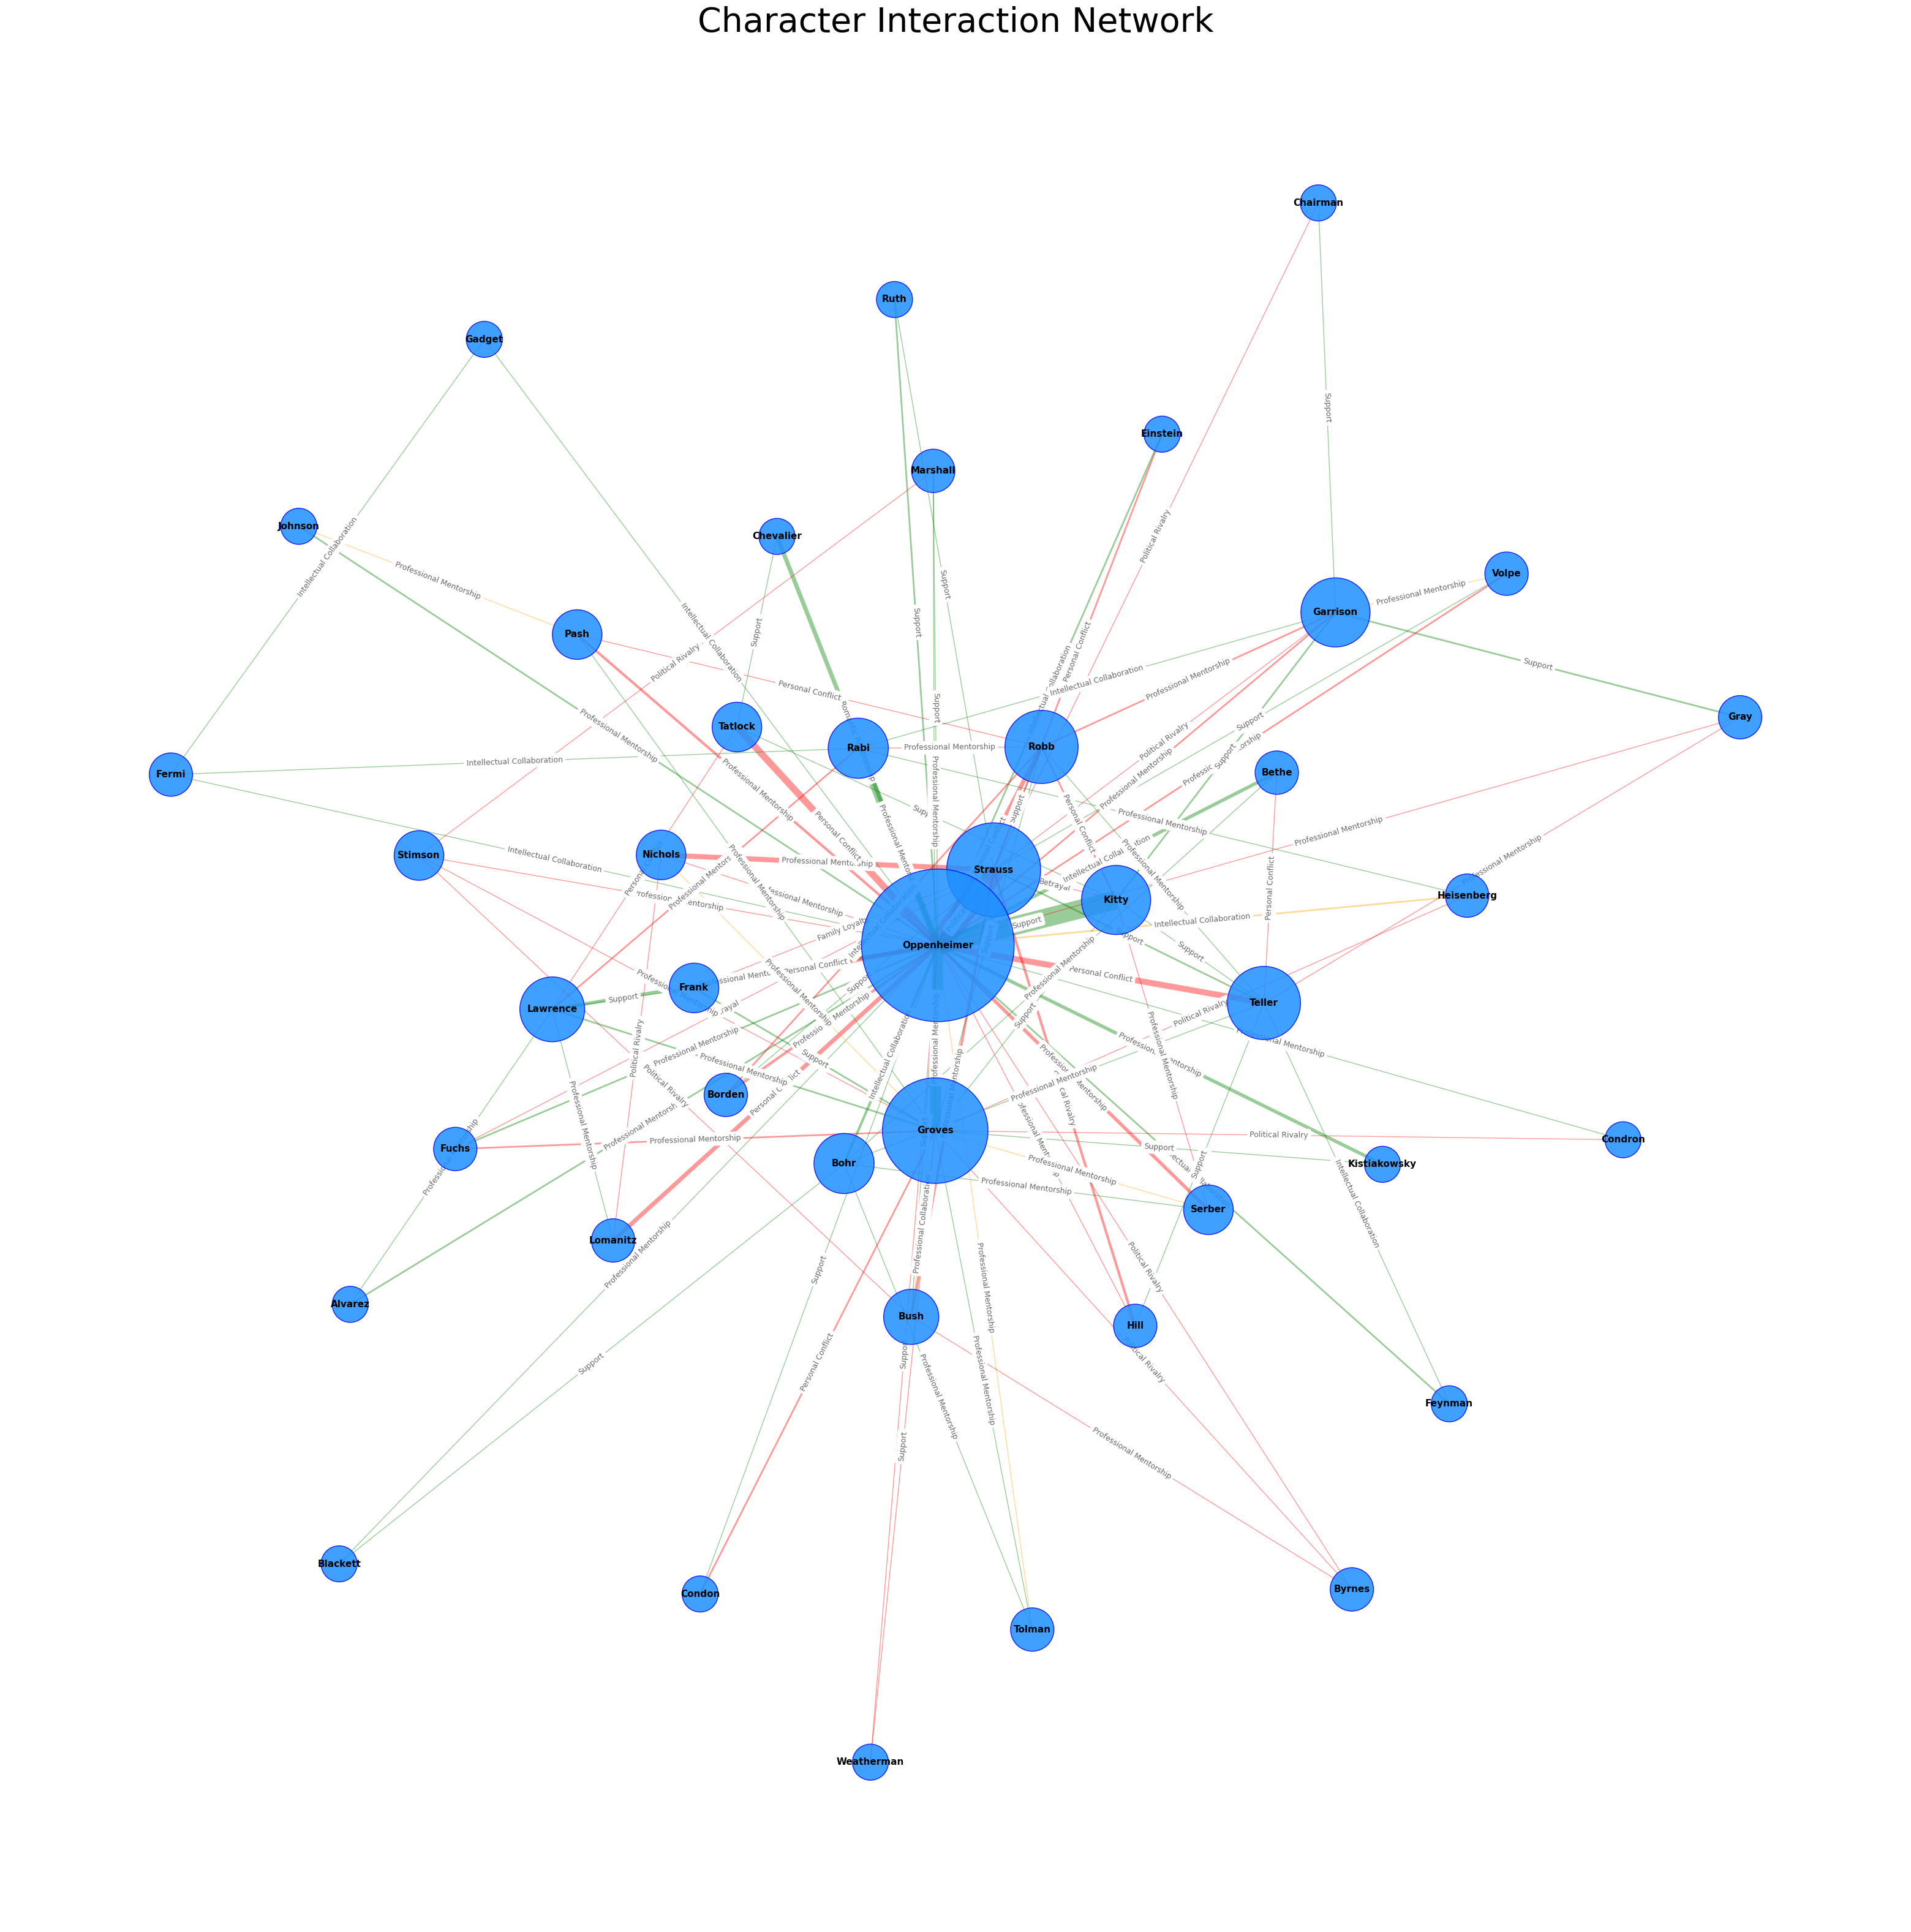

In [159]:
# Plotting the network
plt.figure(figsize=(40, 40))
pos = nx.spring_layout(G, k=1.0, seed=42)

# Draw nodes with customized size and color
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='dodgerblue', edgecolors='blue', alpha=0.85)

# Draw edges with varying thickness based on weight
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.4, edge_color=edge_colors)

# Draw labels for nodes with increased font size, only for nodes with higher degrees
nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")

# Add edge labels for relationship types
edge_labels = nx.get_edge_attributes(G, 'type')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_color="dimgray")

plt.title("Character Interaction Network", fontsize=40)
plt.axis("off")
plt.show()

# Part 4: Network Analysis and Key Metrics

Here, we calculate fundamental network metrics such as density, total nodes and edges, and average degree. These metrics offer an initial quantitative overview of the network, indicating the overall connectivity and interaction density between characters. This analysis helps contextualize the level of inter-character relationships present in the network.


In [160]:
# Calculate graph metrics
density = nx.density(G)
total_nodes = G.number_of_nodes()
total_edges = G.number_of_edges()
average_degree = sum(dict(G.degree()).values()) / total_nodes

# Create a data dictionary for metrics
metrics_data = {
    "Metric": ["Graph Density", "Total Number of Nodes", "Total Number of Edges", "Average Degree"],
    "Value": [density, total_nodes, total_edges, average_degree]
}

# Display the metrics as a table
print(tabulate(metrics_data, headers="keys", tablefmt="fancy_grid"))

╒═══════════════════════╤════════════╕
│ Metric                │      Value │
╞═══════════════════════╪════════════╡
│ Graph Density         │   0.126597 │
├───────────────────────┼────────────┤
│ Total Number of Nodes │  42        │
├───────────────────────┼────────────┤
│ Total Number of Edges │ 109        │
├───────────────────────┼────────────┤
│ Average Degree        │   5.19048  │
╘═══════════════════════╧════════════╛


The graph has a `density of 0.1266`, indicating a relatively sparse network, where only about 13% of all possible connections are present. With a total of `42 nodes` (characters) and `109 edges` (interactions), the network captures a moderate level of character interconnectivity. The `average degree of 5.19` means that each character, on average, interacts with approximately five others, highlighting the importance of key relationships within the character network.

In [161]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Create and populate the DataFrame directly
centrality_df = pd.DataFrame({
    "Character": list(G.nodes()),
    "Degree Centrality": [degree_centrality[char] for char in G.nodes()],
    "Betweenness Centrality": [betweenness_centrality[char] for char in G.nodes()],
    "Closeness Centrality": [closeness_centrality[char] for char in G.nodes()],
    "Eigenvector Centrality": [eigenvector_centrality[char] for char in G.nodes()]
})

# Sort and get the top 10 characters by Degree Centrality
top_10_df = centrality_df.sort_values(by="Degree Centrality", ascending=False).head(10)

# Display the table in plain format
print(tabulate(top_10_df, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═════════════╤═════════════════════╤══════════════════════════╤════════════════════════╤══════════════════════════╕
│ Character   │   Degree Centrality │   Betweenness Centrality │   Closeness Centrality │   Eigenvector Centrality │
╞═════════════╪═════════════════════╪══════════════════════════╪════════════════════════╪══════════════════════════╡
│ Oppenheimer │            0.97561  │               0.709097   │               0.97619  │                 0.535259 │
├─────────────┼─────────────────────┼──────────────────────────┼────────────────────────┼──────────────────────────┤
│ Groves      │            0.463415 │               0.0841463  │               0.640625 │                 0.308827 │
├─────────────┼─────────────────────┼──────────────────────────┼────────────────────────┼──────────────────────────┤
│ Strauss     │            0.365854 │               0.0671545  │               0.61194  │                 0.264927 │
├─────────────┼─────────────────────┼──────────────────────────┼

### Centrality Measures Analysis

This table summarizes the centrality measures for the top characters in the interaction network:

- `Degree Centrality` indicates how well-connected each character is, with Oppenheimer being the most central figure.
- `Betweenness Centrality`measures the extent to which a character lies on paths between others, highlighting Oppenheimer's major influence and Strauss' intermediary role.
- `Closeness Centrality` quantifies how quickly a character can connect with all others in the network, with Oppenheimer having the highest closeness, showing his strategic position in the network.
- `Eigenvector Centrality` ranks Oppenheimer highest, suggesting his importance is not only due to direct connections but also because he is connected to other influential characters, with Groves and Strauss also having substantial influence within the network.


# Part 5: Community Detection

Using the Louvain algorithm, we detect communities within the character interaction network. Each community represents a cluster of closely connected characters who interact more frequently with each other. Visualizing these communities with unique colors provides insights into potential groups or factions within the story, highlighting key alliances and subplots.

In [197]:
# Detect communities using community_louvain
partition = community_louvain.best_partition(G)

In [198]:
# Map each node to its community color
community_colors = list(partition.values())

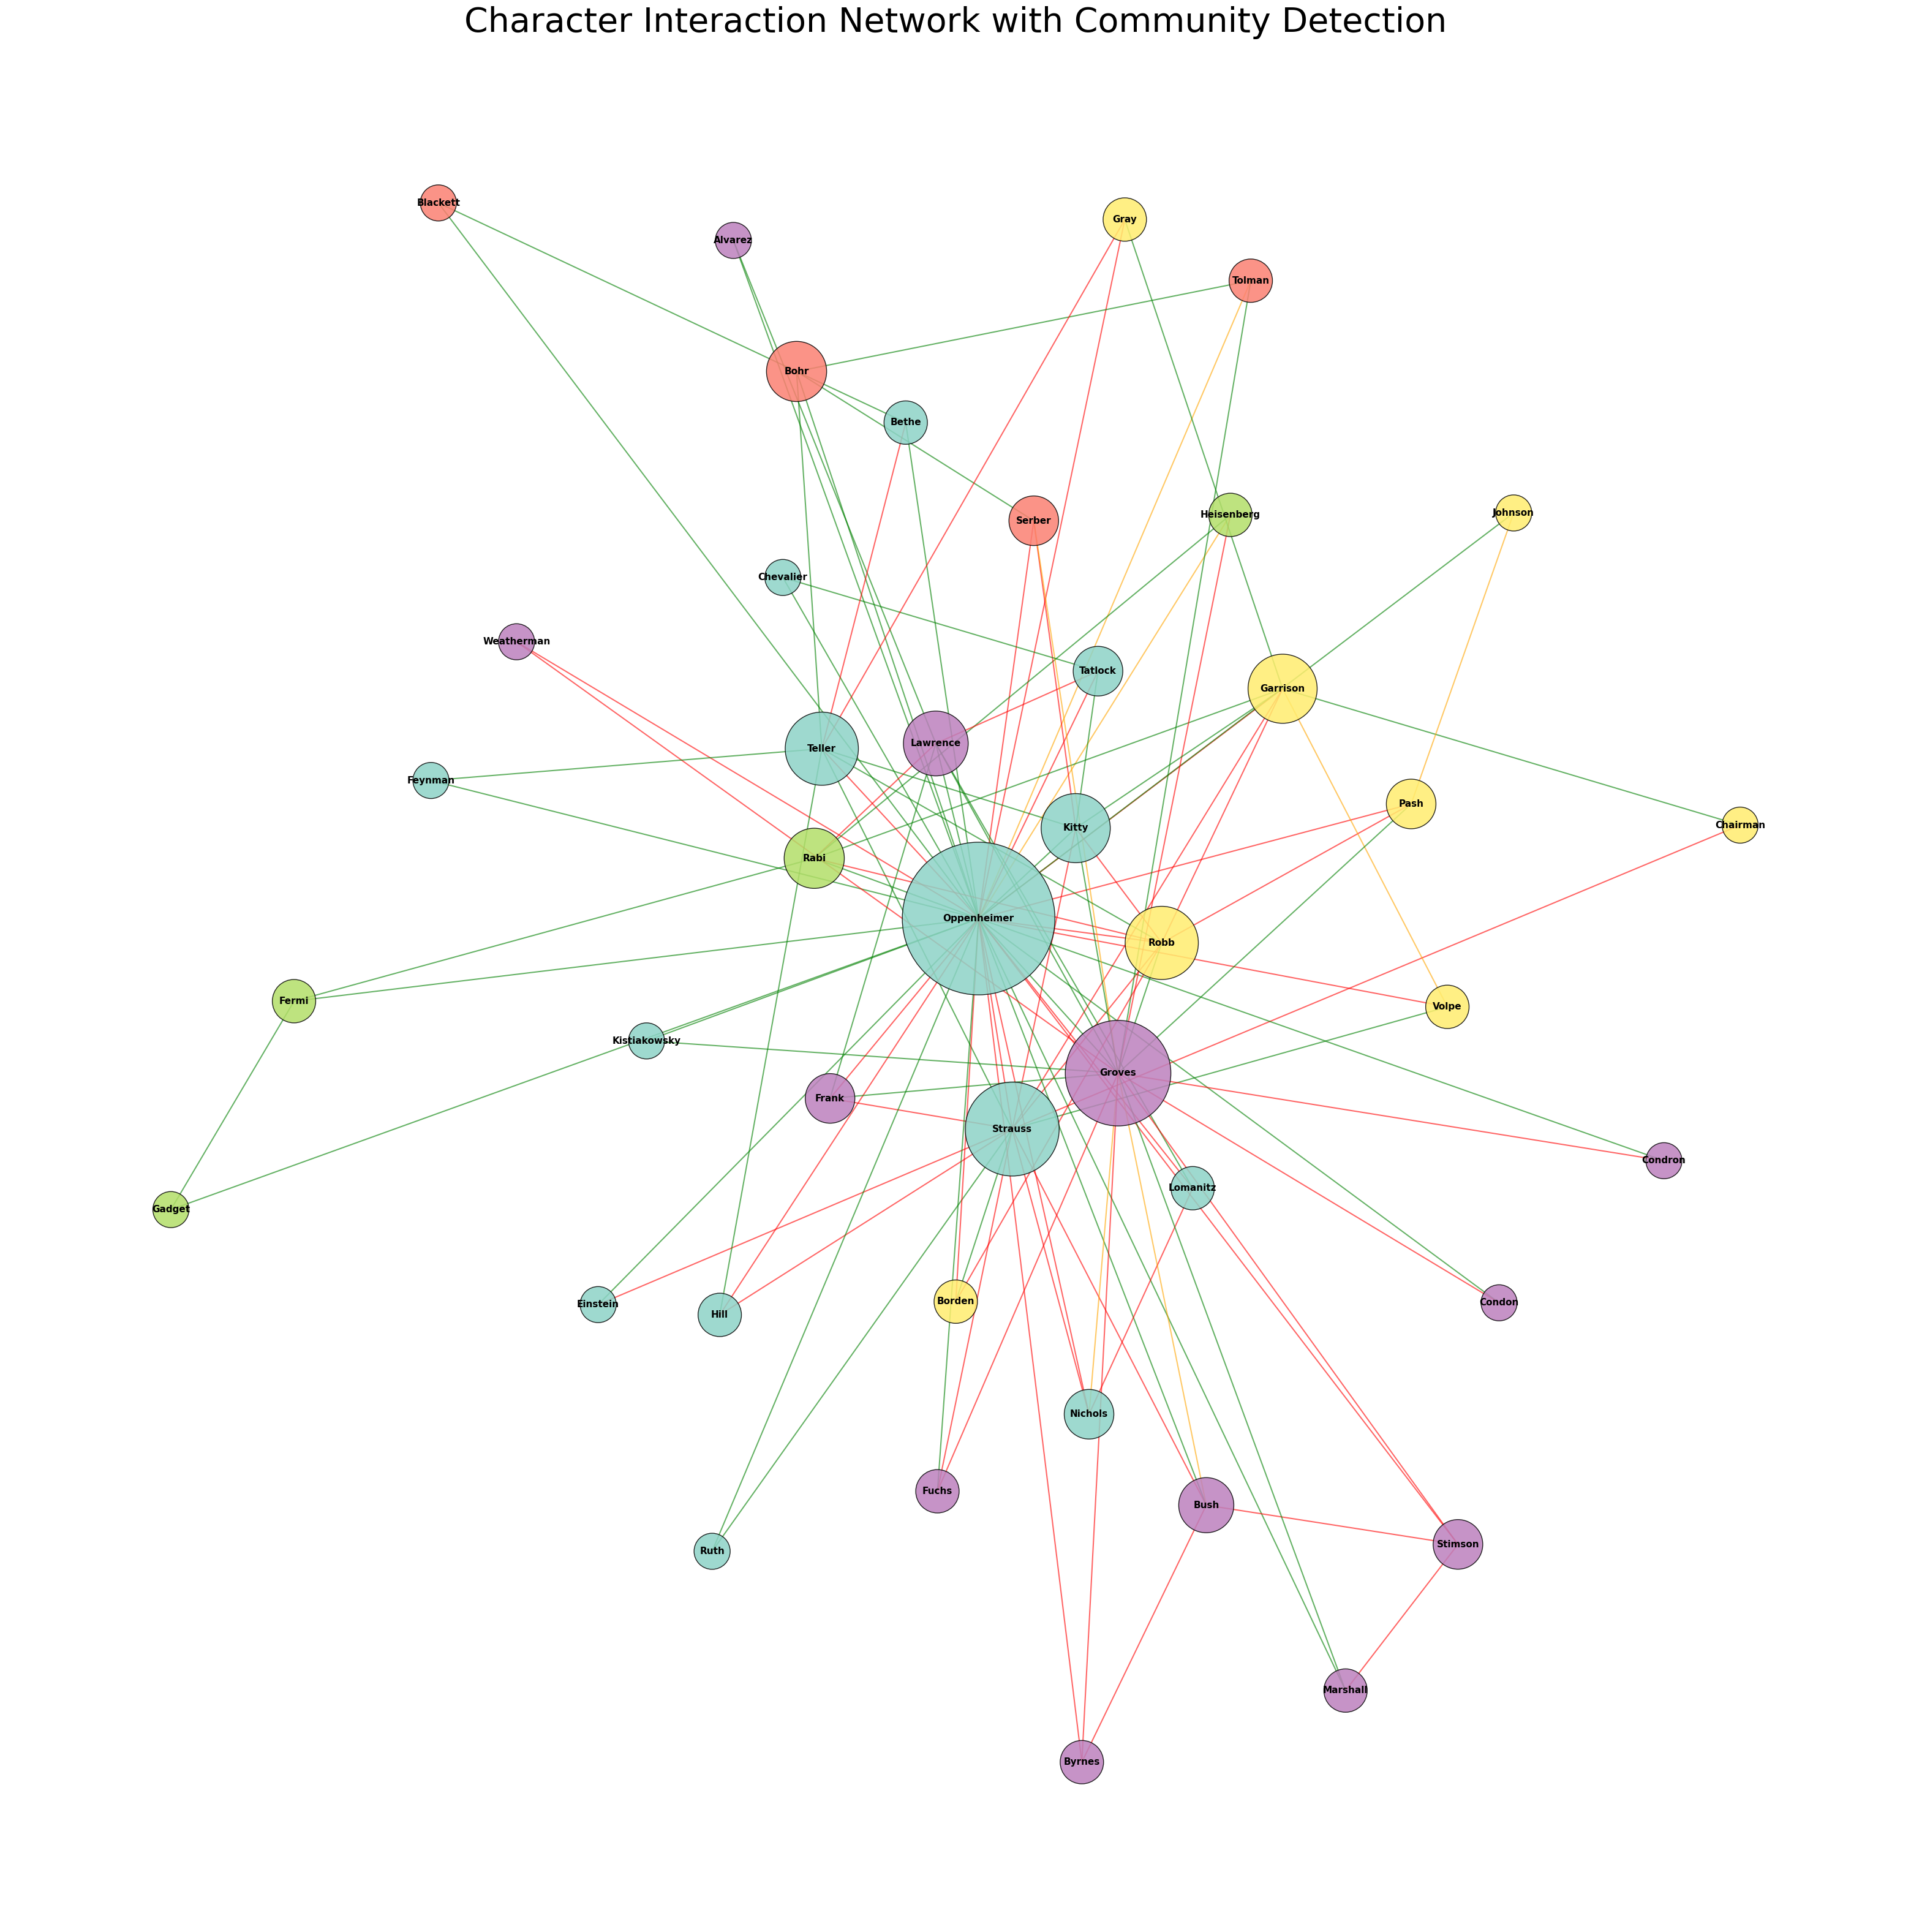

In [199]:
plt.figure(figsize=(40, 40))
pos = nx.spring_layout(G, k=0.5, seed=22)

# Adjust node size and color
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=community_colors, cmap=plt.cm.Set3, edgecolors='black', alpha=0.85)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.6, edge_color=edge_colors)
nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")

plt.title("Character Interaction Network with Community Detection", fontsize=40)
plt.axis("off")
plt.show()

In [200]:
# Compute Average Clustering Coefficient for the whole graph
avg_clustering = nx.average_clustering(G)

# Compute Transitivity of the graph
transitivity = nx.transitivity(G)

print("\nCommunity Analysis Metrics:")
print(f"Average Clustering Coefficient (Whole Graph): {avg_clustering:.4f}")
print(f"Transitivity (Whole Graph): {transitivity:.4f}")


Community Analysis Metrics:
Average Clustering Coefficient (Whole Graph): 0.7326
Transitivity (Whole Graph): 0.1962


`The Average Clustering Coefficient (0.7326)` means that characters in the network tend to form tight groups, where many of their connections are also connected to each other. It basically measures how likely it is for a character's friends to also be friends with each others.

`The Transitivity (0.1962)` which indicates that characters interact more broadly across the network, rather than sticking only to small, tight communities.

In [202]:
# Count themes, relationship types for each community
for cid in set(partition.values()):
    # Get nodes belonging to the current community
    community_nodes = [node for node, community_id in partition.items() if community_id == cid]

    # Filter edges within the current community
    community_edges = [
        data for u, v, data in G.edges(data=True)
        if partition.get(u) == cid and partition.get(v) == cid
    ]

    # Count themes and relationship types
    theme_counts = Counter(data['theme'] for data in community_edges if data.get('theme'))
    relationship_counts = Counter(data['type'] for data in community_edges if data.get('type'))

    # Display results
    print(f"\nCommunity {cid}:")
    print(f"  Sample Characters: {', '.join(community_nodes[:])}")
    if theme_counts:
        print(f"  Top Themes: {theme_counts.most_common(2)}")
    if relationship_counts:
        print(f"  Top Relationships: {relationship_counts.most_common(2)}")


Community 0:
  Sample Characters: Strauss, Oppenheimer, Einstein, Lomanitz, Chevalier, Tatlock, Kitty, Nichols, Feynman, Teller, Bethe, Ruth, Kistiakowsky, Hill
  Top Themes: [('Ambition And Power', 9), ('Friendship And Loyalty', 8)]
  Top Relationships: [('Support', 8), ('Personal Conflict', 5)]

Community 1:
  Sample Characters: Blackett, Bohr, Serber, Tolman
  Top Themes: [('Ambition And Power', 2), ('Friendship And Loyalty', 1)]
  Top Relationships: [('Professional Mentorship', 2), ('Support', 1)]

Community 2:
  Sample Characters: Rabi, Heisenberg, Gadget, Fermi
  Top Themes: [('Ambition And Power', 3)]
  Top Relationships: [('Intellectual Collaboration', 2), ('Professional Mentorship', 1)]

Community 3:
  Sample Characters: Lawrence, Alvarez, Frank, Bush, Groves, Condron, Fuchs, Condon, Stimson, Marshall, Byrnes, Weatherman
  Top Themes: [('Ambition And Power', 10), ('Betrayal And Conflict', 3)]
  Top Relationships: [('Professional Mentorship', 6), ('Political Rivalry', 4)]

Com

The community analysis reveals that "Ambition and Power" is the dominant theme across all detected communities, emphasizing that power dynamics are a core aspect of character interactions.

`Community 0` is the largest, with "Ambition and Power" and "Friendship and Loyalty" as top themes. The key relationships are "Support" and "Personal Conflict," indicating both collaboration and underlying tensions within the group.

`Community 1` also revolves around "Ambition and Power," but it includes significant elements of "Betrayal and Conflict." It shows a mixture of "Political Rivalry" and "Professional Mentorship," suggesting both competitive and cooperative interactions.

`Community 2` features a balance of "Ambition and Power" and "Friendship and Loyalty," with "Professional Mentorship" and "Support" as key relationships, indicating a mentorship-focused environment.

`Community 3` is characterized primarily by "Ambition and Power," with key relationships being "Professional Mentorship" and "Intellectual Collaboration," showing a focus on ambition supported by intellectual partnerships.

`Community 4` also emphasizes "Ambition and Power," with some influence from "Friendship and Loyalty." Its relationships are primarily "Professional Mentorship" and "Support," reflecting mentorship within the community.

Overall, the analysis shows that most communities are driven by ambitions, power struggles, and mentorship, indicating a competitive yet interconnected social structure among the characters.

# Extra: bi-partite network analysis

This section shifts focus to analyze character interactions with significant events using a bipartite network. Here, we classify interactions as active or passive and link characters to specific events, creating a two-mode network. By analyzing this bipartite structure, we can better understand each character's involvement in the storyline’s pivotal moments.

### New Prompt
I will be using two prompts to capture different aspects of the story. The character-to-character prompt focuses on understanding relationships, providing insights into how characters interact with each other. The character-to-event prompt, on the other hand, identifies each character's role and involvement in significant events, highlighting their active or passive contributions. This dual approach allows for a deeper, more structured analysis of both interpersonal dynamics and participation in key plot moments, helping to build richer and more nuanced network representations.








In [ ]:
SYSTEM_PROMPT_CHARACTER = """
Extract interactions between characters and significant events from the given movie script. For each interaction, identify the character involved, the related event, and classify the interaction as either active or passive. Create a bipartite network representation where one set of nodes consists of characters and the other set consists of events. Structure the output in JSON format as follows:

{
 "edges": [
   {"character": "Character Name", "event": "Event Name", "interaction_nature": "Interaction Nature"}
 ]
}

Field Descriptions:
- character: Name of the character involved in the interaction.
- event: Name of the related event.
- interaction_nature: Specify if the interaction is "Active" or "Passive":
   - "Active": The character is actively involved in or directly influencing the event (e.g., organizing, opposing, or participating).
   - "Passive": The character is passively involved or simply present at the event (e.g., attending or observing).

Predefined List of Events:
- "Senate Hearing"
- "AEC Meeting"
- "Press Conference"
- "Physics Symposium"
- "Los Alamos Briefing"
- "Manhattan Project Planning Meeting"
- "Bomb Test at Trinity"
- "Communist Party Gathering"
- "Security Clearance Review"
- "Scientific Debate at Princeton"
- "Government Inquiry"
- "Nuclear Weapon Development Discussion"

Requirements:
- Focus on meaningful interactions between characters and events that contribute significantly to the storyline.
- Each entry should represent a single interaction between a character and an event.
- Only include entries from the predefined list of events.

Examples:
1. {"character": "Oppenheimer", "event": "Senate Hearing", "interaction_nature": "Passive"}
2. {"character": "Strauss", "event": "AEC Meeting", "interaction_nature": "Active"}
3. {"character": "Kitty", "event": "Press Conference", "interaction_nature": "Passive"}

Ensure that the final output is simple, consistent, and uses only the specified event labels and interaction natures.
"""


In [ ]:
def extract_relationships(text_chunk, chunk_id):
    # Create the prompt using the chunk ID for context
    prompt = f"""
    Extract key relationships between characters and events from this text:
    Chunk ID: {chunk_id}
    Text: {text_chunk}
    """

    # Send the prompt to the LLM
    response = ollama.chat(
        model='qwen2.5',
        messages=[
            {'role': 'system', 'content': SYSTEM_PROMPT_CHARACTER},
            {'role': 'user', 'content': prompt},
        ],
        format='json',  # Expecting a JSON format output
        options={"temperature": 0.1}  # Lower temperature for consistency
    )

    # Parse the response content as JSON
    try:
        relationships = json.loads(response['message']['content'])
    except json.JSONDecodeError:
        print(f"Error parsing JSON for Chunk {chunk_id}")
        return None

    # Return the parsed JSON object
    return relationships

In [ ]:
# Initialize a list to store all relationships
all_relationships = []

# Process each chunk
for i, chunk in enumerate(chunks):
    # Extract relationships from the current chunk
    relationships = extract_relationships(chunk, chunk_id=i+1)

    # Check and aggregate the results
    if relationships:
        print(f"Extracted Relationships from Chunk {i+1}:")
        print(relationships)
        all_relationships.extend(relationships['edges'])  # Add relationships to the main list

# Final output with all relationships
if all_relationships:
    print("\nAll Extracted Relationships:")
    for relationship in all_relationships:
        print(relationship)
else:
    print("No relationships found in any chunk.")

NameError: name 'extract_relationships' is not defined

In [ ]:
# Save all relationships to a JSON file in Google Colab
with open("/content/extracted_bipartite.json", "w") as f:
    json.dump(all_relationships, f, indent=2)

print("File saved as extracted_bipartite.json in Google Colab.")

File saved as extracted_bipartite.json in Google Colab.


In [8]:
# Load the data
with open('/content/extracted_bipartite.json', 'r') as file:
    data = json.load(file)

In [9]:
# Preview the first few entries in the list
print("First few entries in the data:")
for edge in data[:5]:
    print(edge)

First few entries in the data:
{'character': 'Oppenheimer', 'event': 'Senate Hearing', 'interaction_nature': 'Active'}
{'character': 'Strauss', 'event': 'Senate Hearing', 'interaction_nature': 'Passive'}
{'character': 'Strauss', 'event': 'Senate Hearing', 'interaction_nature': 'Passive'}
{'character': 'Strauss', 'event': 'Security Clearance Review', 'interaction_nature': 'Active'}
{'character': 'Oppenheimer', 'event': 'Senate Hearing', 'interaction_nature': 'Active'}


In [10]:
# Count and display the top 15 events by frequency
event_counts = Counter(entry['event'] for entry in data)
print("Top 15 Event Counts (sorted by frequency):")
for event, count in event_counts.most_common(15):
    print(f"{event}: {count}")

Top 15 Event Counts (sorted by frequency):
Senate Hearing: 104
Security Clearance Review: 71
Bomb Test at Trinity: 70
AEC Meeting: 45
Los Alamos Briefing: 41
Government Inquiry: 33
Scientific Debate at Princeton: 27
Manhattan Project Planning Meeting: 20
Communist Party Gathering: 19
Press Conference: 18
Physics Symposium: 9
Theoretical Physics Department Work: 3
Atomic Pile Visit: 3
Institute for Advanced Study Planning Meeting: 2
Lecture on Quantum Mechanics: 2


In [11]:
# Filter out entries with missing values
filtered_data = [entry for entry in data if "character" in entry and "event" in entry and "interaction_nature" in entry]

In [12]:
# Create a list of tuples representing character-event pairs and count their occurrences
interaction_tuples = [(entry['character'], entry['event']) for entry in filtered_data]
interaction_counter = Counter(interaction_tuples)

In [13]:
# Display the most frequent interactions and their counts
for interaction, count in interaction_counter.most_common(5):
    print(f"{interaction[0]} - {interaction[1]}: {count} times")

Strauss - Senate Hearing: 29 times
Oppenheimer - Senate Hearing: 27 times
Oppenheimer - Security Clearance Review: 22 times
Strauss - AEC Meeting: 20 times
Oppenheimer - Bomb Test at Trinity: 18 times


In [34]:
# Initialize a bipartite graph
B = nx.Graph()

# Add nodes and weighted edges to the graph
for (character, event), weight in interaction_counter.items():
    B.add_node(character, bipartite=0)
    B.add_node(event, bipartite=1)
    B.add_edge(character, event, weight=weight)

In [35]:
# Separate nodes by type in the bipartite graph
character_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
event_nodes = set(B) - character_nodes

In [41]:
# Calculate metrics
total_nodes = B.number_of_nodes()
total_edges = B.number_of_edges()
avg_degree_characters = sum(B.degree(n) for n in character_nodes) / len(character_nodes)
avg_degree_events = sum(B.degree(n) for n in event_nodes) / len(event_nodes)

In [42]:
# Creating a data dictionary for metrics and improving the readability
metrics_data = {
    "Metric": ["Total Number of Nodes", "Total Number of Edges", "Average Degree (Characters)", "Average Degree (Events)"],
    "Value": [total_nodes, total_edges, round(avg_degree_characters, 2), round(avg_degree_events, 2)]
}

# Display the metrics as a table using tabulate
print(tabulate(metrics_data, headers="keys", tablefmt="fancy_grid"))

╒═════════════════════════════╤═════════╕
│ Metric                      │   Value │
╞═════════════════════════════╪═════════╡
│ Total Number of Nodes       │  112    │
├─────────────────────────────┼─────────┤
│ Total Number of Edges       │  191    │
├─────────────────────────────┼─────────┤
│ Average Degree (Characters) │    2.58 │
├─────────────────────────────┼─────────┤
│ Average Degree (Events)     │    5.03 │
╘═════════════════════════════╧═════════╛


In [43]:
# Calculate degree for each node type and get the top characters and events
character_degree = Counter({node: B.degree(node) for node in character_nodes})
event_degree = Counter({node: B.degree(node) for node in event_nodes})

top_characters = [node for node, _ in character_degree.most_common(10)]
top_events = [node for node, _ in event_degree.most_common(5)]

In [44]:
# Filter data to include only the top characters and events
top_filtered_data = [
    entry for entry in filtered_data
    if entry["character"] in top_characters and entry["event"] in top_events
]

### Top Characters and Events Graph
Here I will make a subgraph only using the `top events` and `top characters` to improve the presenation and readability



In [89]:
# Here I will make another graph for the top characters and events
B_filtered = nx.Graph()

In [90]:
# Add nodes and edges to the filtered graph
for entry in top_filtered_data:
    character = entry["character"]
    event = entry["event"]
    interaction_nature = entry["interaction_nature"]

    B_filtered.add_node(character, bipartite=0)
    B_filtered.add_node(event, bipartite=1)
    B_filtered.add_edge(character, event, interaction_nature=interaction_nature, weight=interaction_counter[(character, event)])

In [91]:
# Calculate degree centrality for the filtered bipartite graph
centrality = nx.degree_centrality(B_filtered)

In [92]:
# Scale centrality values for node size
node_sizes = [5000 * centrality[node] for node in B_filtered.nodes()]

In [93]:
# Set positions for nodes: characters on the left, events on the right
pos = {}
pos.update((node, (1, i * 2)) for i, node in enumerate(n for n in B_filtered if B_filtered.nodes[n]["bipartite"] == 0))  # Characters
pos.update((node, (2, i * 2)) for i, node in enumerate(n for n in B_filtered if B_filtered.nodes[n]["bipartite"] == 1))  # Events

In [94]:
# Define node colors based on their type
node_colors = ['skyblue' if B_filtered.nodes[node]["bipartite"] == 0 else 'khaki' for node in B_filtered.nodes()]

# Define edge colors based on interaction nature
edge_colors = ['green' if B_filtered[u][v]['interaction_nature'] == 'Active' else 'red' for u, v in B_filtered.edges()]

# Define edge weights based on the weight attribute
edge_weights = [data['weight'] for _, _, data in B_filtered.edges(data=True)]  # Edge width is based on the weight

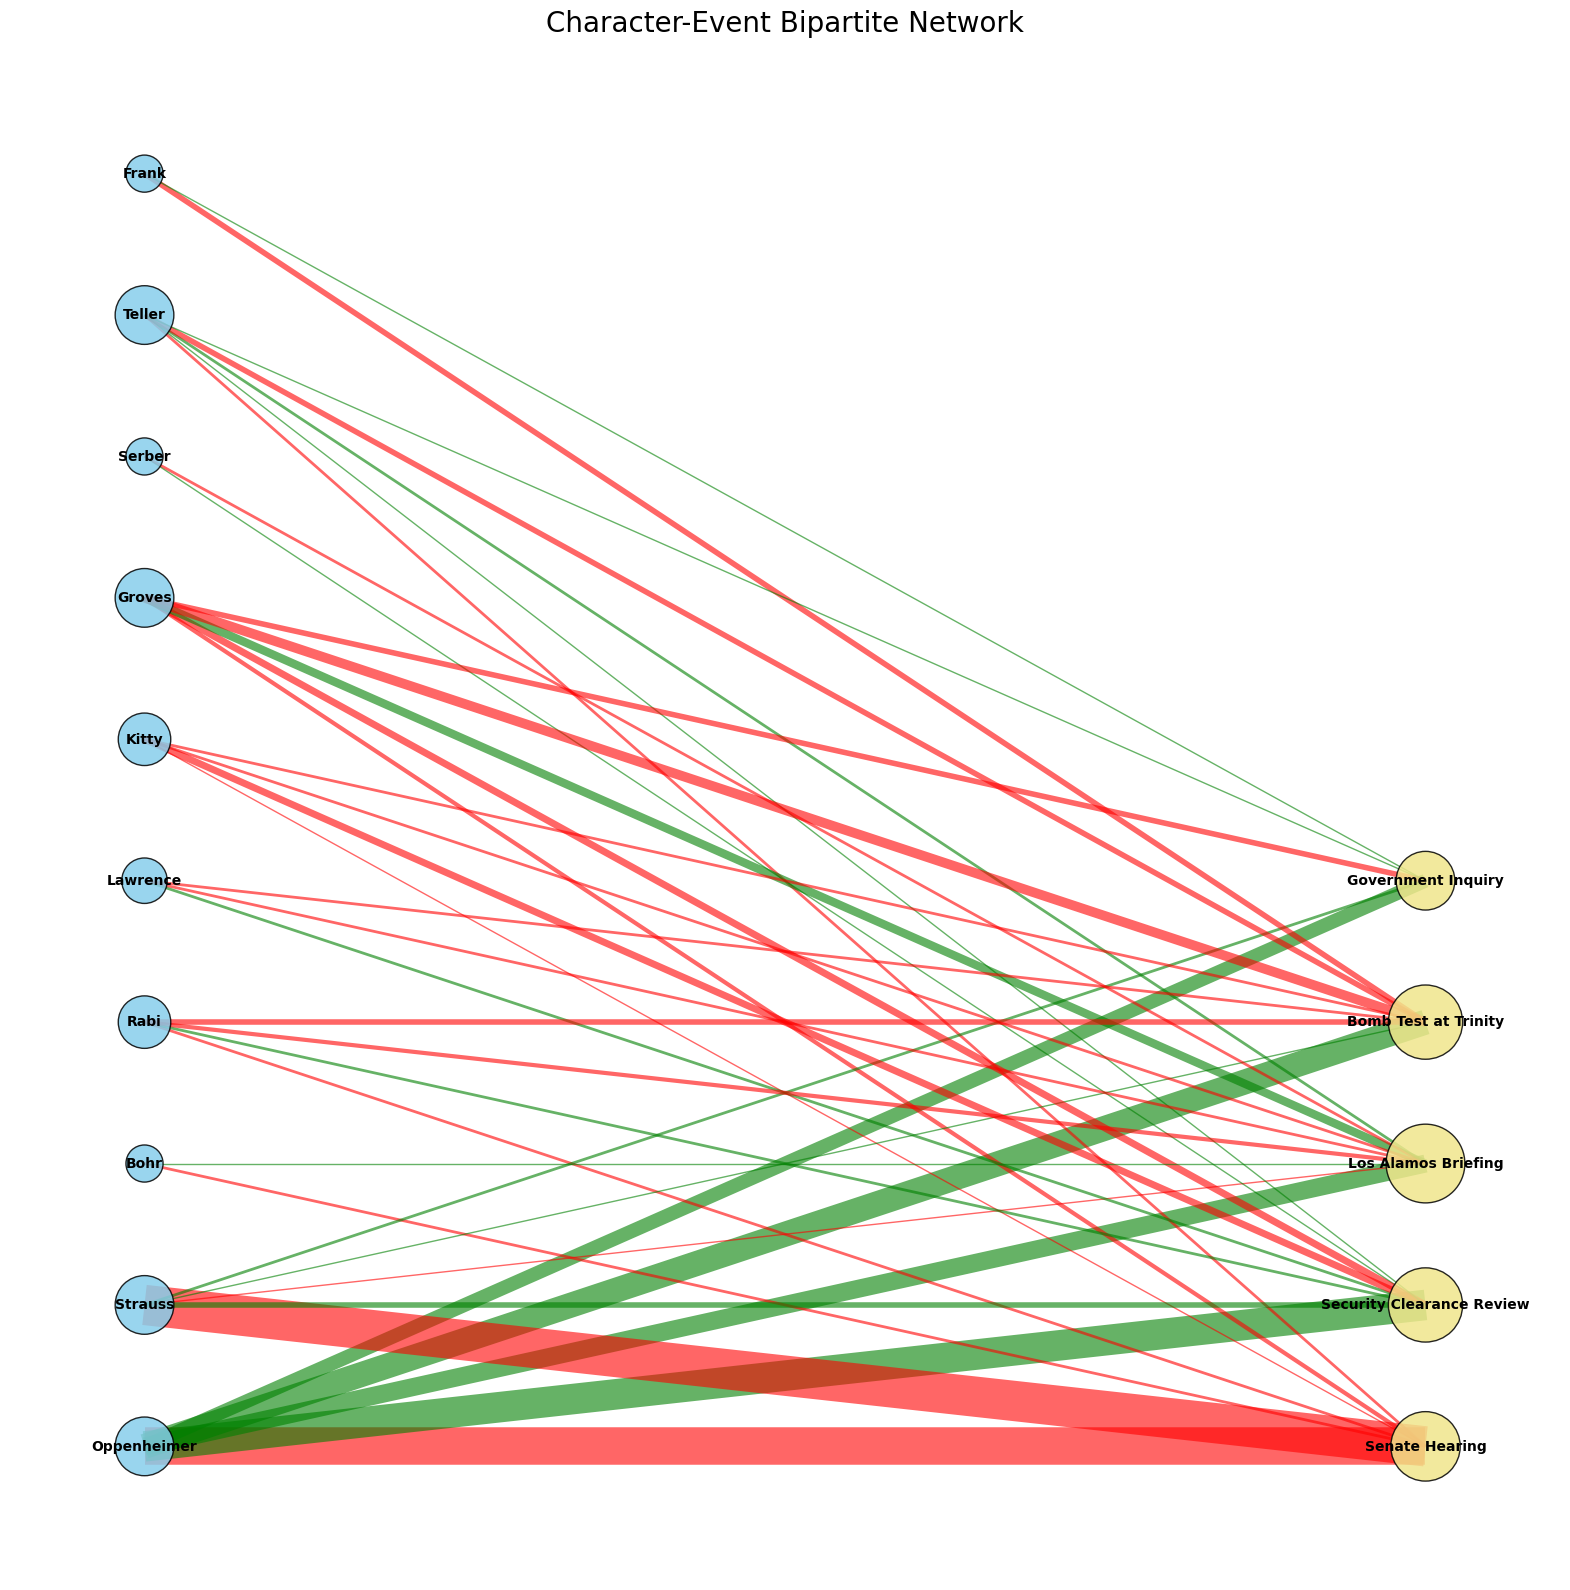

In [97]:
# Plot the filtered bipartite graph with centrality-based node sizes
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(B_filtered, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black', alpha=0.85)
nx.draw_networkx_edges(B_filtered, pos, width=edge_weights, alpha=0.6, edge_color=edge_colors)
nx.draw_networkx_labels(B_filtered, pos, font_size=10, font_weight="bold", font_color='black')

plt.title("Character-Event Bipartite Network", fontsize=20)
plt.axis("off")
plt.show()


This bipartite network shows interactions between characters (in blue) and events (in yellow). The thickness of the edges represents the frequency of interaction, while colors indicate the nature of the involvement—green for active participation and red for passive. Oppenheimer and Strauss are most heavily connected to key events, suggesting they have significant influence or involvement across multiple critical moments. The graph effectively visualizes which characters are central to major events and how their interactions differ in intensity and nature.

# Network Analysis and Key Centralities
In the final section, we calculate and display centrality scores for the top characters and events within the bipartite network. Using degree, betweenness, and eigenvector centrality, we highlight characters and events that play significant roles. The results are presented in a clear table, summarizing the most critical nodes within the character-event network.

In [50]:
# Calculate centrality measures for B_filtered
degree_centrality = nx.degree_centrality(B_filtered)
betweenness_centrality = nx.betweenness_centrality(B_filtered)

# Only calculate eigenvector centrality if the graph is connected
eigenvector_centrality = nx.eigenvector_centrality(B_filtered) if nx.is_connected(B_filtered) else None

# Create a DataFrame for top characters
top_characters_df = pd.DataFrame({
    "Character": top_characters,
    "Degree Centrality": [degree_centrality[char] for char in top_characters],
    "Betweenness Centrality": [betweenness_centrality[char] for char in top_characters],
})

# Include Eigenvector Centrality if calculated
if eigenvector_centrality:
    top_characters_df["Eigenvector Centrality"] = [eigenvector_centrality[char] for char in top_characters]
else:
    top_characters_df["Eigenvector Centrality"] = None

# Sort the table
top_characters_df = top_characters_df.sort_values(by="Degree Centrality", ascending=False)

# Display the table using the fancy grid format
print("\nTop Characters Centrality Scores:")
print(tabulate(top_characters_df, headers='keys', tablefmt='fancy_grid', showindex=False))


Top Characters Centrality Scores:
╒═════════════╤═════════════════════╤══════════════════════════╤══════════════════════════╕
│ Character   │   Degree Centrality │   Betweenness Centrality │   Eigenvector Centrality │
╞═════════════╪═════════════════════╪══════════════════════════╪══════════════════════════╡
│ Oppenheimer │            0.357143 │               0.0519285  │                0.278728  │
├─────────────┼─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Strauss     │            0.357143 │               0.0519285  │                0.278728  │
├─────────────┼─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Groves      │            0.357143 │               0.0519285  │                0.278728  │
├─────────────┼─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Teller      │            0.357143 │               0.0519285  │                0.278728  │
├─────────────┼─────────────────────┼────────

This table summarizes the `centrality scores for key characters` in the bipartite network of characters and events. Oppenheimer, Strauss, Groves, and Teller rank highest in degree, betweenness, and eigenvector centrality, indicating their significant involvement in multiple events and influence across different interactions.

In [51]:
# Create a DataFrame for top events
top_events_df = pd.DataFrame({
    "Event": top_events,
    "Degree Centrality": [degree_centrality[event] for event in top_events],
    "Betweenness Centrality": [betweenness_centrality[event] for event in top_events],
})

# Include eigenvector centrality if calculated
if eigenvector_centrality:
    top_events_df["Eigenvector Centrality"] = [eigenvector_centrality[event] for event in top_events]
else:
    top_events_df["Eigenvector Centrality"] = None

# Sort the table
top_events_df = top_events_df.sort_values(by="Degree Centrality", ascending=False)

# Display the table using the fancy grid format
print("\nTop Events Centrality Scores:")
print(tabulate(top_events_df, headers='keys', tablefmt='fancy_grid', showindex=False))


Top Events Centrality Scores:
╒═══════════════════════════╤═════════════════════╤══════════════════════════╤══════════════════════════╕
│ Event                     │   Degree Centrality │   Betweenness Centrality │   Eigenvector Centrality │
╞═══════════════════════════╪═════════════════════╪══════════════════════════╪══════════════════════════╡
│ Los Alamos Briefing       │            0.642857 │                0.211746  │                 0.36167  │
├───────────────────────────┼─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Bomb Test at Trinity      │            0.571429 │                0.163371  │                 0.33559  │
├───────────────────────────┼─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Security Clearance Review │            0.571429 │                0.13193   │                 0.340365 │
├───────────────────────────┼─────────────────────┼──────────────────────────┼──────────────────────────┤
│ Senate Hearin

The table shows `centrality scores for key events` in the bipartite network, highlighting their importance. Los Alamos Briefing has the highest centrality across all metrics, indicating a crucial role. The Bomb Test at Trinity and Security Clearance Review also show strong centrality values, reflecting their significant impact.










# Summary
In this notebook, the Oppenheimer movie script was analyzed to create several network graphs that explore the relationships within the storyline. The analysis focused on both character interactions and their connections to significant events. Using techniques like community detection, centrality analysis, and bipartite graph modeling, we gained insights into the dynamics between characters, key themes, and key moments in the plot.








